In [1]:
import pandas as pd
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from numpy import interp
from sklearn.metrics import precision_recall_curve, auc, f1_score
from sklearn.model_selection import learning_curve, StratifiedKFold
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder

In [2]:
import nbformat

nb = nbformat.read("Lab1-2021.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 407


## Student 1
### Name :Yuqian Song
### ID :4630521

**How to run?**

- Make a new conda env with ```conda create -n cyber_data python=3.9```
- In the env ```pip install -r requirements.txt```

### Preprocessing

In [3]:
def conv(row):
    #Define conversion rates
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}

    #Convert amount to EUR
    return row['amount'] / (currency_dict[row['currencycode']] * 100)


def preprocess(df):
    #Prepare card id and ip id for plotting
    # 1.Card ID
    card_enc = LabelEncoder()
    card_enc.fit(df['card_id'])
    df['card_id'] = card_enc.transform(df.card_id)

    # 2.IP ID
    ip_enc = LabelEncoder()
    ip_enc.fit(df['ip_id'])
    df['ip_id'] = ip_enc.transform(df.ip_id)

    #Encoding, Fill missing values
    df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
    df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = 'ZZ'
    df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = 'ZZ'

    #Convert transaction amount to EUR
    df['amount_eur'] = df.apply(lambda x: conv(x), axis=1)

    #Clean mail_id
    df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'
    enc6 = LabelEncoder()
    enc6.fit(df['mail_id'])
    df['mail_id'] = enc6.transform(df.mail_id)

    #Merge cvcresponsecode categories
    df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

    #Feature Engineering(create new feature)
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1

    df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account', '', x))
    df['accountcode_cc'] = 0
    df.loc[(df['accountcode'] == 'UK'), 'accountcode_cc'] = 'GB'
    df.loc[(df['accountcode'] == 'Mexico'), 'accountcode_cc'] = 'MX'
    df.loc[(df['accountcode'] == 'Sweden'), 'accountcode_cc'] = 'SE'
    df.loc[(df['accountcode'] == 'APAC'), 'accountcode_cc'] = 'APAC'

    #Select features
    preprocessed = df[['issuercountrycode', 'txvariantcode', 'bin', 'amount', 'currencycode', 'shoppercountrycode',
                       'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
                       'mail_id', 'ip_id', 'card_id', 'amount_eur', 'countries_equal', 'label']]

    #Use ordinal encoding from pd.pandas
    data_converted = preprocessed.copy()
    data_converted['issuercountrycode'] = data_converted['issuercountrycode'].astype('category').cat.codes
    data_converted['txvariantcode'] = data_converted['txvariantcode'].astype('category').cat.codes
    data_converted['currencycode'] = data_converted['currencycode'].astype('category').cat.codes
    data_converted['shoppercountrycode'] = data_converted['shoppercountrycode'].astype('category').cat.codes
    data_converted['shopperinteraction'] = data_converted['shopperinteraction'].astype('category').cat.codes
    data_converted['cardverificationcodesupplied'] = data_converted['cardverificationcodesupplied'].astype(
        'category').cat.codes
    data_converted['cvcresponsecode'] = data_converted['cvcresponsecode'].astype('category').cat.codes
    data_converted['accountcode'] = data_converted['accountcode'].astype('category').cat.codes
    data_converted['mail_id'] = data_converted['mail_id'].astype('category').cat.codes
    data_converted['ip_id'] = data_converted['ip_id'].astype('category').cat.codes
    data_converted['card_id'] = data_converted['card_id'].astype('category').cat.codes

    return data_converted


### Miscellaneous:
Extra classes for training and plotting

In [4]:
class Trainer:

    def __init__(self,  X_train, y_train, X_test, y_test, random_state=30):
        """
        Initializes the Trainier with several machine learning models
        :param random_state: for determinism
        """
        self.random_state = random_state
        self.svc = svm.LinearSVC(random_state=self.random_state, dual=True, max_iter=5000)
        self.rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=self.random_state)
        self.lr = LogisticRegression(solver='newton-cholesky', C=100, n_jobs=-1, random_state=self.random_state)
        self.black_box = BaggingClassifier(estimator=self.lr, n_estimators=10, random_state=200, n_jobs=-1)
        self.white_box = self.lr
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def train_black_box(self):
        """
        Trains the 'black_box' model (a BaggingClassifier) on provided training data.
        :param X_train: X_train
        :param y_train: y_train
        :return: trained model
        """
        self.black_box.fit(self.X_train, self.y_train)

    def get_block_box_auc(self):
        """
        Calculates and returns the ROC AUC score for the 'black_box' model
        :param X_test: X_test
        :param y_test: y_test
        :return: roc_auc_score
        """
        bagging_proba = self.black_box.predict_proba(self.X_test)
        return roc_auc_score(self.y_test, bagging_proba[:, 1])

    def get_auc(self):
        """
        Calculates and returns the ROC AUC scores for all 3 models
        :param X_test: X_test
        :param y_test: y_test
        :return: scores
        """

        y_proba_svc = self.svc._predict_proba_lr(self.X_test)
        y_probar_rfc = self.rfc.predict_proba(self.X_test)
        y_proba_lr = self.lr.predict_proba(self.X_test)

        fpr, tpr, _ = roc_curve(self.y_test, y_proba_svc[:, 1])
        roc_auc_svc = roc_auc_score(self.y_test, y_proba_svc[:, 1])  # Calculate ROC AUC score

        fpr, tpr, _ = roc_curve(self.y_test, y_probar_rfc[:, 1])
        roc_auc_rfc = roc_auc_score(self.y_test, y_probar_rfc[:, 1])  # Calculate ROC AUC score

        fpr, tpr, _ = roc_curve(self.y_test, y_proba_lr[:, 1])
        roc_auc_lr = roc_auc_score(self.y_test, y_proba_lr[:, 1])  # Calculate ROC AUC score

        return roc_auc_svc, roc_auc_rfc, roc_auc_lr

    def train_svc_rf_lr_classifiers(self):
        """
        Trains on all 3 classifiers
        :param X_train: X_train
        :param y_train: y_train
        :return: trained classifiers
        """

        #SVC
        self.svc.fit(self.X_train, self.y_train)
        print("Finished training on SVC")

        #Random Forest
        self.rfc.fit(self.X_train, self.y_train)
        print("Finished training on RFC")

        #LR
        self.lr.fit(self.X_train, self.y_train)
        print("Finished training on LR")



In [5]:
class Plotter:

    def __init__(self, X, y):
        """
        Initializes the plotter with train dataset and labels
        :param X: X
        :param y: y
        """
        self.X = X
        self.y = y




def plot_sklearn_roc_curve( y_real, y_pred, title):
    """
    Plots the ROC curve for a specific model
    :param y_real: y_real
    :param y_pred: y_pred
    :param title: title of plot
    :return:
    """
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_auc = roc_auc_score(y_real, y_pred)  # Calculate ROC AUC score

    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5, 5)
    plt.plot([0, 1], [0, 1], color='g')

    plt.title(title)
    plt.text(0.6, 0.2, f"AUC = {roc_auc:.4f}", fontsize=12,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    plt.show()


def plot( models, X_test, y_test ):
    """
    Plots the Roc curve for all 3 models
    :param models:  models       #SVM, Random Forest, Logisitc Regression
    :param X_test: X_test
    :param y_test: y_test
    :return: plots
    """

    y_proba = models[0]._predict_proba_lr(X_test)
    y_probarfc = models[1].predict_proba(X_test)
    y_probalr = models[2].predict_proba(X_test)

    plot_sklearn_roc_curve(y_test, y_proba[:, 1], "SVM")
    plot_sklearn_roc_curve(y_test, y_probarfc[:, 1], "Random Forest")
    plot_sklearn_roc_curve(y_test, y_probalr[:, 1], "Logistic Regression")

    plt.figure(figsize=(10, 6))
    plt.suptitle("ROC Curve Analysis", fontsize=16)
    plt.show()


## 3. Privacy task – 1 A4 – Individual

In [6]:
def rank_swap(data, p, random_state=None):
    """
    Rank swapping for a given dataset.

    Parameters:
    data (list of lists): The dataset.
    p (int): The number of rows to consider when selecting a row to swap.

    Returns:
    data (list of lists): The dataset with rank swapped rows.
    """

    data = np.array(data)
    # Get the number of attributes and rows in the dataset.
    num_attrs = data.shape[1]
    num_rows = data.shape[0]

    rng = np.random.default_rng(random_state)

    # For each attribute...
    for i in range(num_attrs):
        # Get the sorted indices
        sorted_indices = np.argsort(data[:, i])
        sorted_data = data[sorted_indices, i]

        # For each row...
        for j in range(num_rows):
            p_min = max(0, j - p)
            p_max = min(num_rows - 1, j + p)

            # Select a row to swap with
            r_prime = rng.integers(p_min, p_max + 1)

            # Swap the actual values in the sorted data
            sorted_data[j], sorted_data[r_prime] = sorted_data[r_prime], sorted_data[j]

        # Assign sorted and swapped data back to the original dataset
        data[sorted_indices, i] = sorted_data

    return data[:, :-1], data[:, -1]


### 3a. Print ROC curves

Finished processing data


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


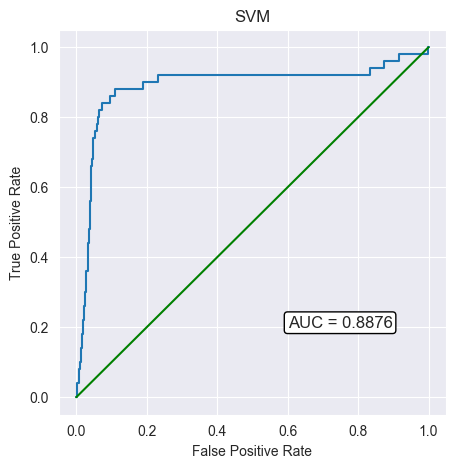

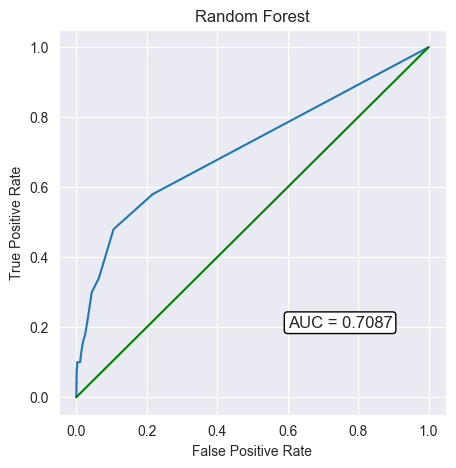

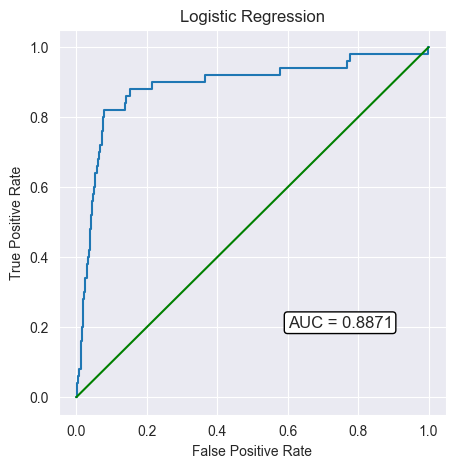

<Figure size 1000x600 with 0 Axes>

In [7]:

from sklearn.decomposition import PCA

pd_data = pd.read_csv('train_data.csv')
preprocessed = preprocess(pd_data)
data = preprocessed.to_numpy()

data_transformed = preprocessed.to_numpy()
X = data_transformed[:, :-1]
y = data_transformed[:, -1].astype(int)

pipe = Pipeline([('scaler', StandardScaler()),  ('pca', PCA(0.99))])
Xt = pipe.fit_transform(X, y)
random_state = 200

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=random_state)
print("Finished processing data")

data = np.column_stack((X_train, y_train))

X_res, y_res = rank_swap(data, p=1000, random_state=random_state)
t = Trainer(X_res, y_res, X_test, y_test)
t.train_svc_rf_lr_classifiers()
plot([t.svc, t.rfc, t.lr],X_test, y_test)

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

From the graphs above it is apparent that SVM performs best for a k of 1000. But SVM and lr seems to have a similar AUC. However, to truly analyze the performance lets compare the auc scores for different p values

C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


C:\Users\akash\anaconda3\envs\cyber_data\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training on SVC
Finished training on RFC
Finished training on LR


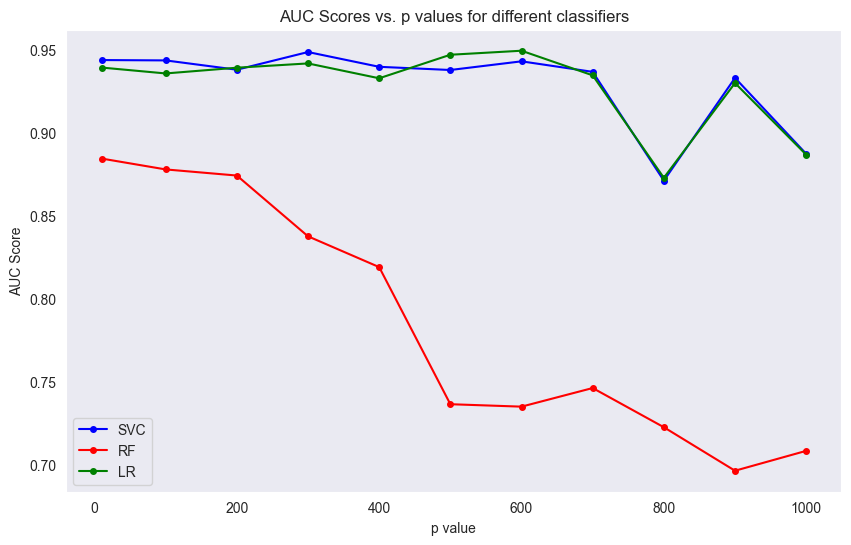

In [9]:

# The list of p values
p_values = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
auc_scores_svc = []
auc_scores_rf = []
auc_scores_lr = []

for p in p_values:
    X_res, y_res = rank_swap(data, p=p, random_state=random_state)
    t = Trainer(X_res, y_res, X_test, y_test)
    t.train_svc_rf_lr_classifiers()


    score_svc, score_rf, score_lr = t.get_auc()

    # Compute the AUC score for each classifier and add it to the respective list
    auc_scores_svc.append(score_svc)
    auc_scores_rf.append(score_rf)
    auc_scores_lr.append(score_lr)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(p_values, auc_scores_svc, marker='o', markersize=4, color='blue', label='SVC')
plt.plot(p_values, auc_scores_rf, marker='o', markersize=4, color='red', label='RF')
plt.plot(p_values, auc_scores_lr, marker='o', markersize=4, color='green', label='LR')

plt.title('AUC Scores vs. p values for different classifiers')
plt.xlabel('p value')
plt.ylabel('AUC Score')
plt.legend()
plt.grid()
plt.show()


As can be seen from the above graphs, SVM and Logistic regression are rather stable in auc score as p value increases, rf on the other hand is much more infuenced by this


### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

I would say it depends on how the p value. As you can see from the graph above as the p value increases the performance decreases too. For SVC and LR there is a 0.5 decrease while the decrease is exponential for random forest. Do note that 1000 fore p value is just 1% of the total number of rows, therefore for p values such as 10000 where you have more randomness and privacy obfuscation but very bad performance.